/Users/josebraz/opt/anaconda3/lib/python3.9/site-packages/pysal/explore/segregation/network/network.py:15: UserWarning: You need pandana and urbanaccess to work with segregation's network module
You can install them with  `pip install urbanaccess pandana` or `conda install -c udst pandana urbanaccess`
  warn(


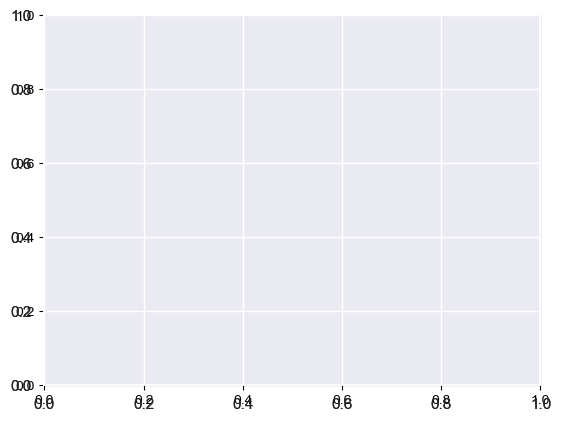

In [1]:
import numpy as np
import geopandas as gpd
import shapely

from explore import *
from utils import *

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import contextily as cx

# dados de https://appeears.earthdatacloud.nasa.gov

In [2]:

def evaluate_gpd(reference: gpd.GeoDataFrame, other: gpd.GeoDataFrame,
                 reference_value_column: str = 'value', 
                 other_value_column: str = 'value'):
    """
    | other \ reference | queimada | não queimada |
    |-------------------|----------|--------------|
    |     queimada      |    TP    |      FP      |
    |   não queimada    |    FN    |      TN      |
    |-------------------|----------|--------------|
    """
    original_geometry = other['geometry']
    other['geometry'] = other.representative_point()
    join_gpd = gpd.sjoin(reference, other, predicate="contains", lsuffix='reference', rsuffix='other')
    other['geometry'] = original_geometry
    
    same_names = reference_value_column == other_value_column
    burned_reference = np.array(join_gpd[reference_value_column + ('_reference' if same_names else '')])
    burned_other = np.array(join_gpd[other_value_column + ('_other' if same_names else '')])
    unburned_reference = np.array(1.0 - join_gpd[reference_value_column + ('_reference' if same_names else '')])
    unburned_other = np.array(1.0 - join_gpd[other_value_column + ('_other' if same_names else '')])

    def calculate_same(array1, array2):
        min_array = np.array([array1, array2]).min(axis=0)
        min_array[np.isnan(min_array)] = 0.0
        return min_array.sum()
    
    def calculate_diff(array1, array2):
        temp1 = array1[array1 > array2]
        temp2 = array2[array1 > array2]
        diff = (temp1 - temp2)
        return diff.sum()

    TP = calculate_same(burned_reference, burned_other) # True Positive
    FN = calculate_diff(burned_reference, burned_other) # False Negative
    FP = calculate_diff(burned_other, burned_reference) # False Positive
    TN = calculate_same(unburned_reference, unburned_other) # True Negative

    ACC = (TP + TN) / (TP + FP + FN + TN)
    TPR = TP / (TP + FN) # true positive rate
    TNR = TN / (TN + FP) # true negative rate
    PPV = TP / (TP + FP) # positive predictive value 
    NPV = TN / (TN + FN) # negative predictive value
    OE = FN / (FN + TP) 
    CE = FP / (FP + TP)
    B  = (TP + FP) / (TP + FN) # viés
    DC = 2 * TP / (2 * TP + FP + FN)
    CSI = TP / (TP + FP + FN)

    return { 'TP': TP, 'FP': FP, 'FN': FN, 'TN': TN,
             'ACC': ACC, 'CE': CE, 'OE': OE, 'B': B, 
             'DC': DC, 'TPR': TPR, 'TNR': TNR, 'PPV': PPV, 
             'NPV': NPV, 'CSI': CSI }


In [3]:
df = read_burn_df()

In [4]:
def compare_aqm_and_explore(aqm_gdf: gpd.GeoDataFrame, explore_df: pd.DataFrame, 
                            xmin = None, xmax = None, ymin = None, ymax = None, 
                            quadrat_width = 0.005, ax1: plt.Axes = None, 
                            ax2: plt.Axes = None, normatized: bool = False):
    if ax1 is None:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 10), sharey=True, sharex=True)
        fig.tight_layout()

    bounds = None if xmin is None else shapely.geometry.box(xmin, ymin, xmax, ymax)
    normalized = aqm_gdf if normatized else normalize_gdf(aqm_gdf, bounds, quadrat_width)
    normalized[normalized['value'] > 0].plot(column='value', ax=ax1, cmap='hot', linewidth=0.0, legend=True)
    cx.add_basemap(ax1, crs=normalized.crs.to_string())

    data_temp = explore_df if xmin is None else sub_space(explore_df, ymin, ymax, xmin, xmax)
    explorer = SatellitesExplore(data_temp, quadrat_width=quadrat_width, 
                                 burned_area_calc=polinomial_burned_area_calc(1, 10, 2),
                                 min_area_percentage=0.02,
                                 threshold_satellite=1)
    # explorer.show_satellites_areas(ax=ax2)
    explorer.show_satellites_quads_areas(ax=ax2, linewidth=0, cmap='hot')
    cx.add_basemap(ax2, crs=explorer.dataframe.crs.to_string())

    burned = explorer.get_burned_areas()
    temp = gpd.GeoDataFrame(
        { 'value': burned['burned_factor'], 'geometry': burned['geometry'] },
        crs = burned.crs
    )
    evaluate = evaluate_gpd(normalized, temp)
    ax2.set_title(f"""ACC = {int(evaluate['ACC'] * 100)}%, CE = {int(evaluate['CE'] * 100)}%, OE = {int(evaluate['OE'] * 100)}%""")
    return (evaluate, normalized, temp)

In [5]:
def compare_aqm_and_explore_multiple(aqm_gdfs: list[gpd.GeoDataFrame], explore_dfs: list[pd.DataFrame], 
                                     xmin = None, xmax = None, ymin = None, ymax = None, 
                                     quadrat_width = 0.005, normatized: bool = False):
    size = len(aqm_gdfs)
    fig, axs = plt.subplots(size, 2, figsize=(25, size * 10), sharey=True, sharex=True)
    fig.tight_layout()
    for index, (aqm_file, explore_df) in enumerate(zip(aqm_gdfs, explore_dfs)):
        (ax1, ax2) = axs[index]
        data, aqm, explore = compare_aqm_and_explore(aqm_file, explore_df, xmin, xmax, ymin, ymax, 
                                       quadrat_width, ax1, ax2, normatized)
        time = explore_df.iloc[0]['datahora']
        ax1.set_title(f'Time: {time}')

In [7]:
path, row, quadrat_width = 221, 67, 0.005
geometry = get_landsat_geometry(path, row)
aqm_gdfs = [normalize_gdf(gpd.read_file('tiff/LS8_AQM_221_067_20210703_0107'), geometry, quadrat_width), 
            normalize_gdf(gpd.read_file('tiff/LS8_AQM_221_067_20210719_0107'), geometry, quadrat_width), 
            normalize_gdf(gpd.read_file('tiff/LS8_AQM_221_067_20210804_0107'), geometry, quadrat_width), 
            normalize_gdf(gpd.read_file('tiff/LS8_AQM_221_067_20210820_0107'), geometry, quadrat_width)]
explore_dfs = [sub_space_by_landsat(df.query("'2021-06-18 00:00:00-03:00' < datahora < '2021-07-03 23:59:59-03:00'"), path, row),
               sub_space_by_landsat(df.query("'2021-07-03 00:00:00-03:00' < datahora < '2021-07-19 23:59:59-03:00'"), path, row),
               sub_space_by_landsat(df.query("'2021-07-19 00:00:00-03:00' < datahora < '2021-08-04 23:59:59-03:00'"), path, row), 
               sub_space_by_landsat(df.query("'2021-08-05 00:00:00-03:00' < datahora < '2021-08-20 23:59:59-03:00'"), path, row)]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


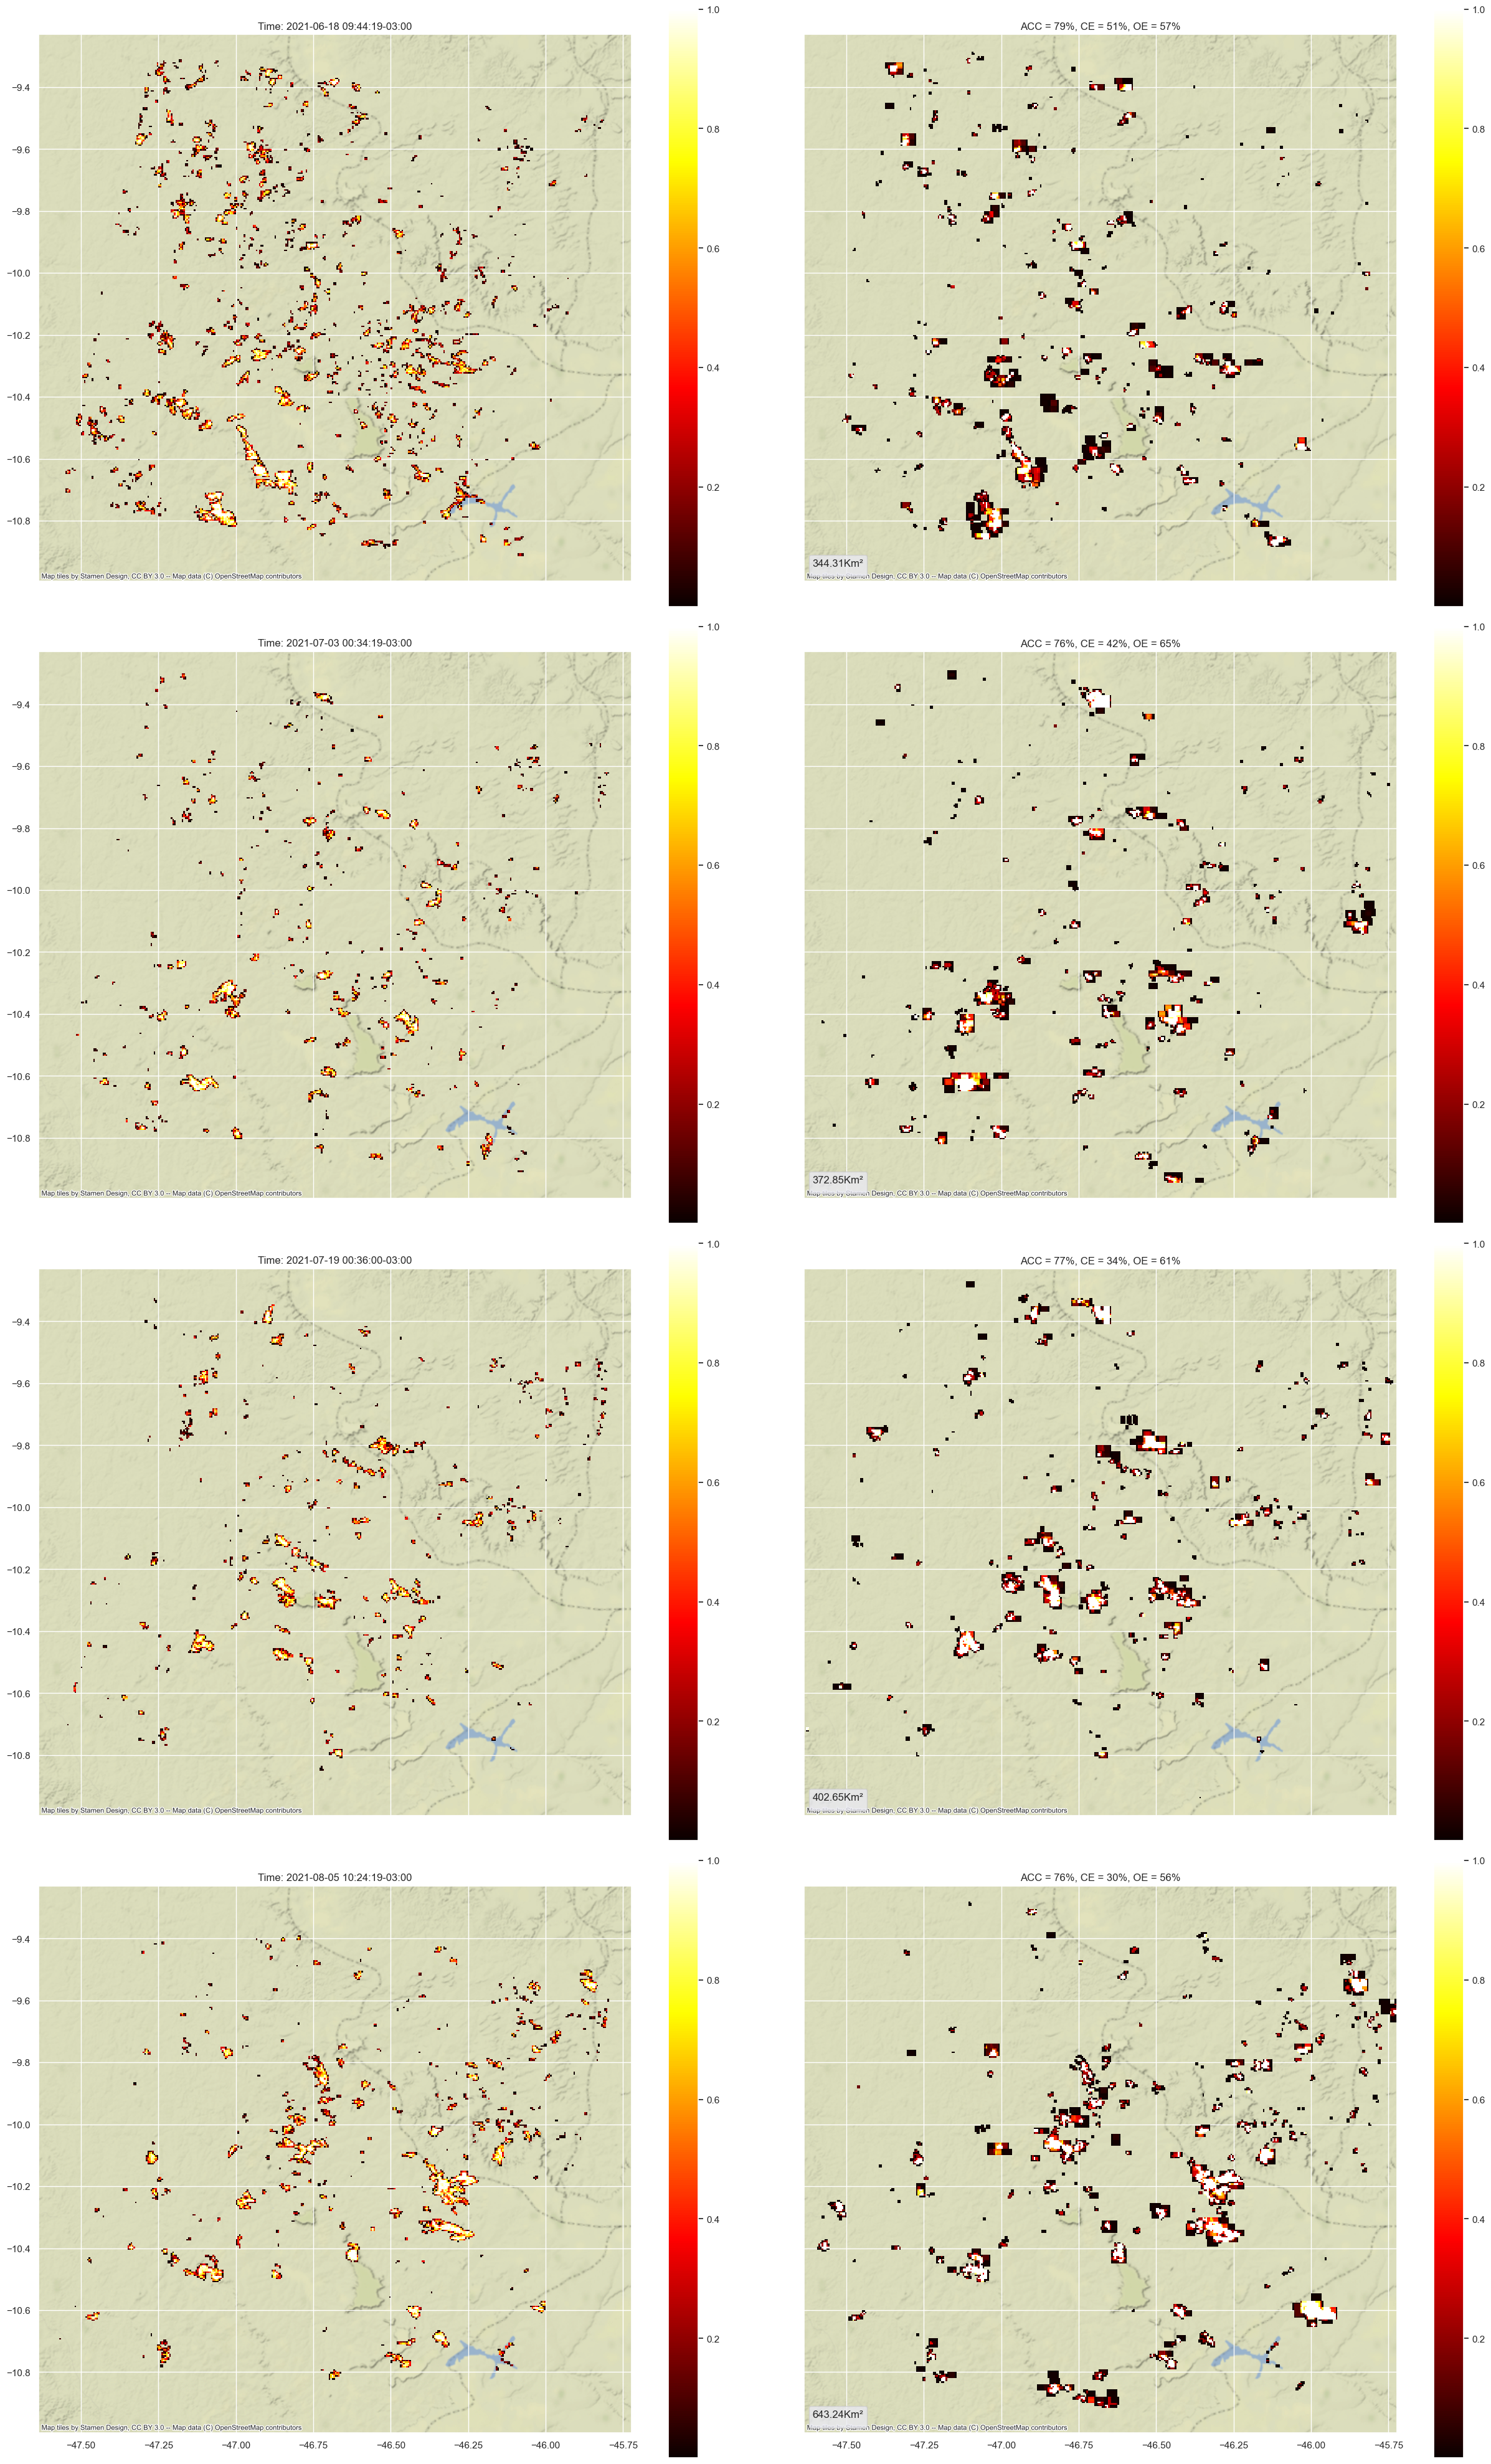

In [94]:
# Validação com o AQ30km
compare_aqm_and_explore_multiple(aqm_gdfs, explore_dfs, quadrat_width=quadrat_width, normatized=True)

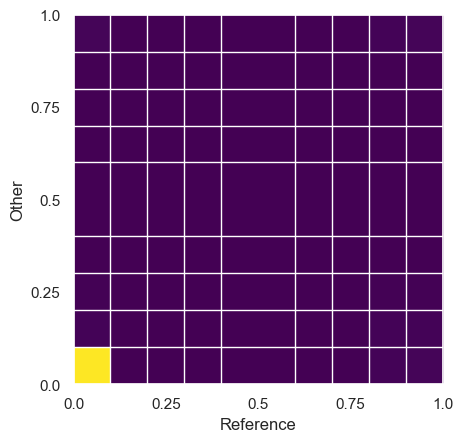

In [177]:

def compare_values(values1: np.array, values2: np.array, n: int = 10, 
                   values1_label: str = 'Other', values2_label: str = 'Reference'):
    bins = np.linspace(0.0, 1.0, n)
    inds1 = np.digitize(values1, bins)
    inds2 = np.digitize(values2, bins)

    count = np.array([[np.min([np.sum(inds1 == i+1), np.sum(inds2 == j+1)]) for j in range(n)] for i in range(n)])

    fig, ax = plt.subplots(1, 1)
    ax.imshow(np.flip(count, 0), cmap='viridis', extent=[0, 1, 0, 1])

    ax.set_xticks(np.linspace(0.0, 1.0, 5))
    ax.set_yticks(np.linspace(0.0, 1.0, 5))
    ax.set_xticks(np.linspace(0.0, 1.0, n+1), minor=True)
    ax.set_yticks(np.linspace(0.0, 1.0, n+1), minor=True)
    ax.set_xticklabels(np.linspace(0.0, 1.0, 5))
    ax.set_yticklabels(np.linspace(0.0, 1.0, 5))
    ax.set_ylabel(values1_label)
    ax.set_xlabel(values2_label)

    ax.grid(False)
    ax.grid(which='minor', color='w', linestyle='-', linewidth=1)

values1 = explore['value'].values
values2 = aqm['value'].values
compare_values(values1, values2)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


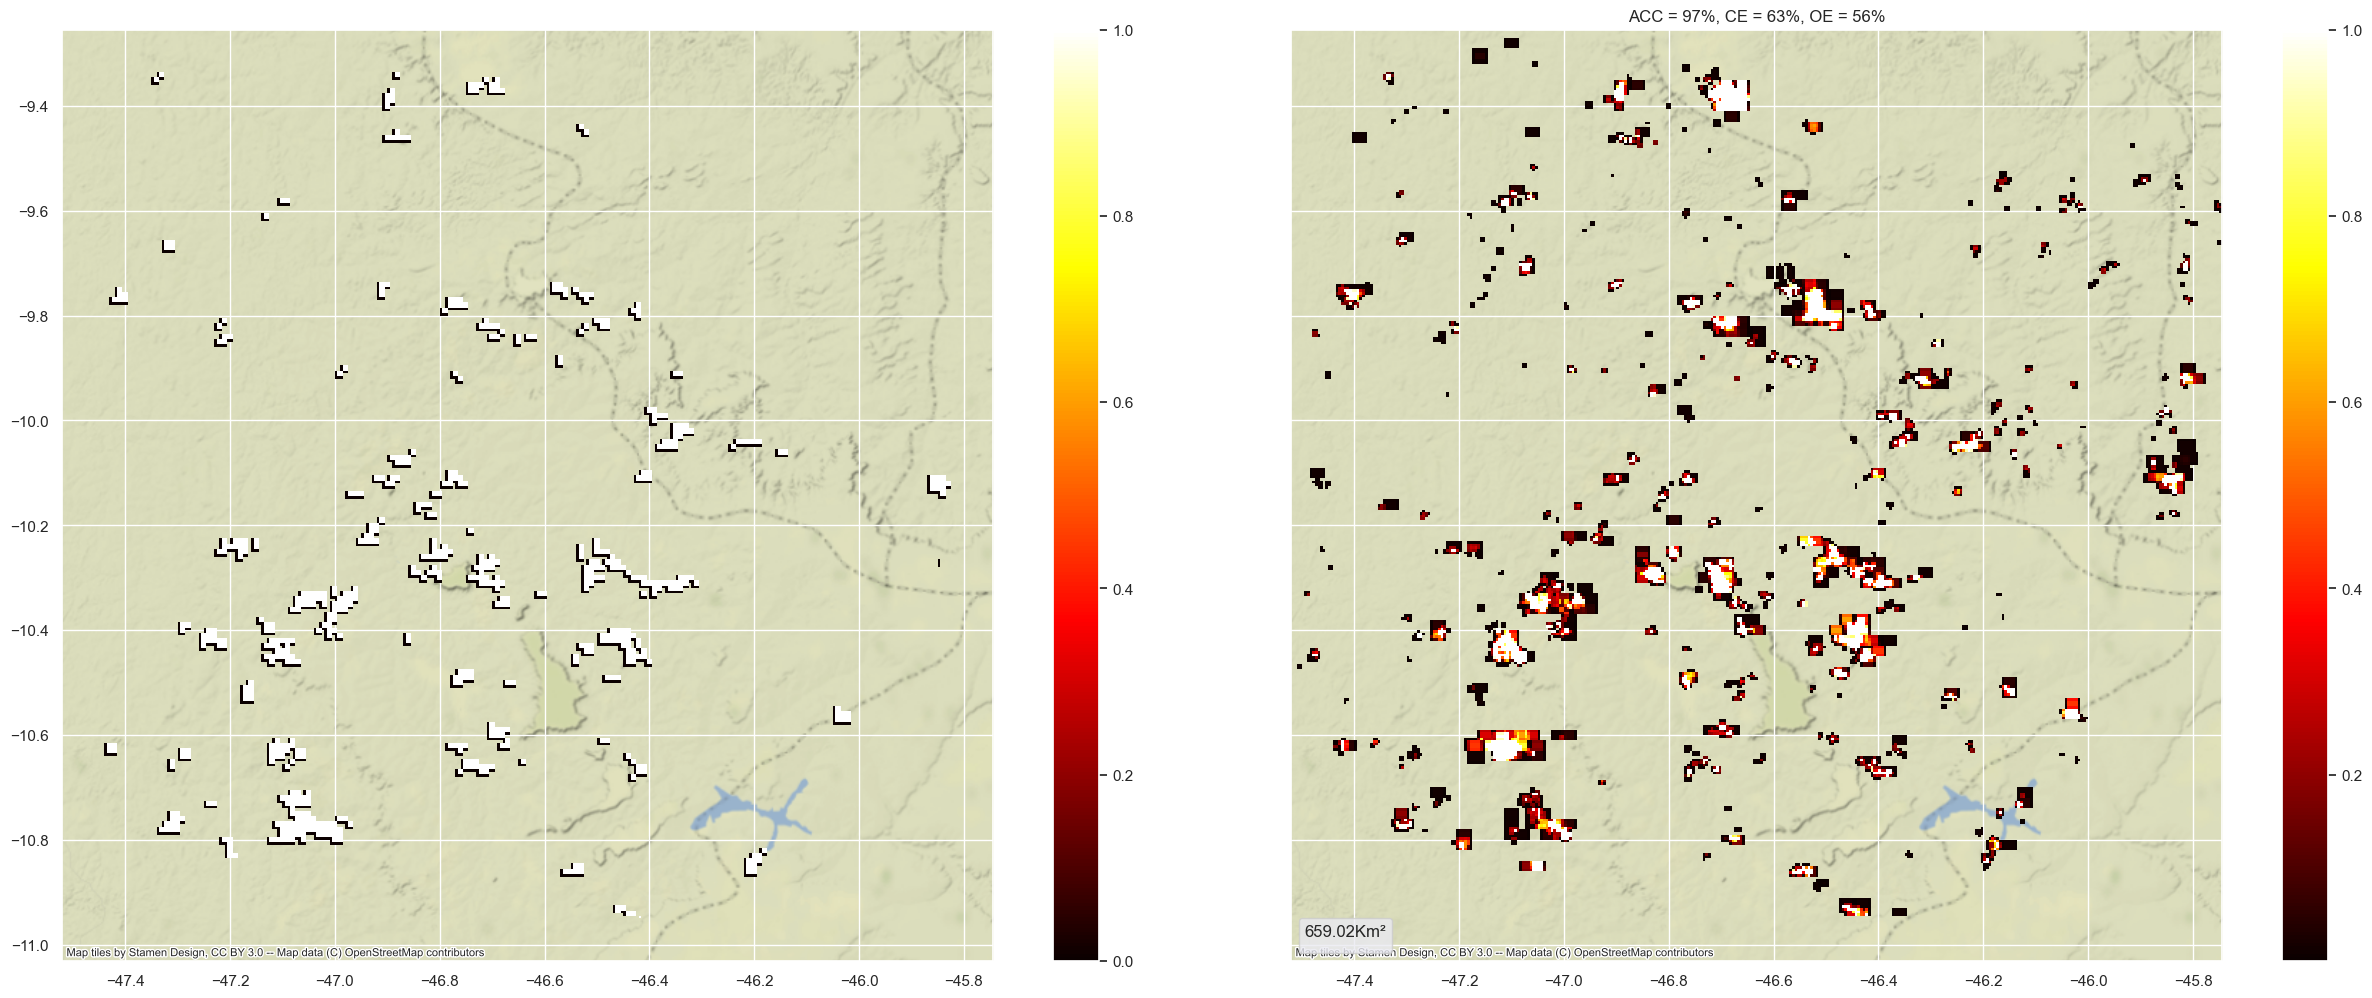

In [178]:
## Validaçao com o AQ1km
path, row, quadrat_width = 221, 67, 0.005
geometry = get_landsat_geometry(path, row)
aqm1km_gdf = normalize_gdf(gpd.read_file('tiff/aq1km/shp/2021_07_01_aq1km_V6.zip'), geometry, quadrat_width)
explore_temp_gdf = sub_space_by_landsat(df.query("'2021-07-01 00:00:00-03:00' < datahora < '2021-07-31 23:59:59-03:00'"), path, row)
data, aqm, explore = compare_aqm_and_explore(aqm1km_gdf, explore_temp_gdf, quadrat_width=quadrat_width, normatized=True)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


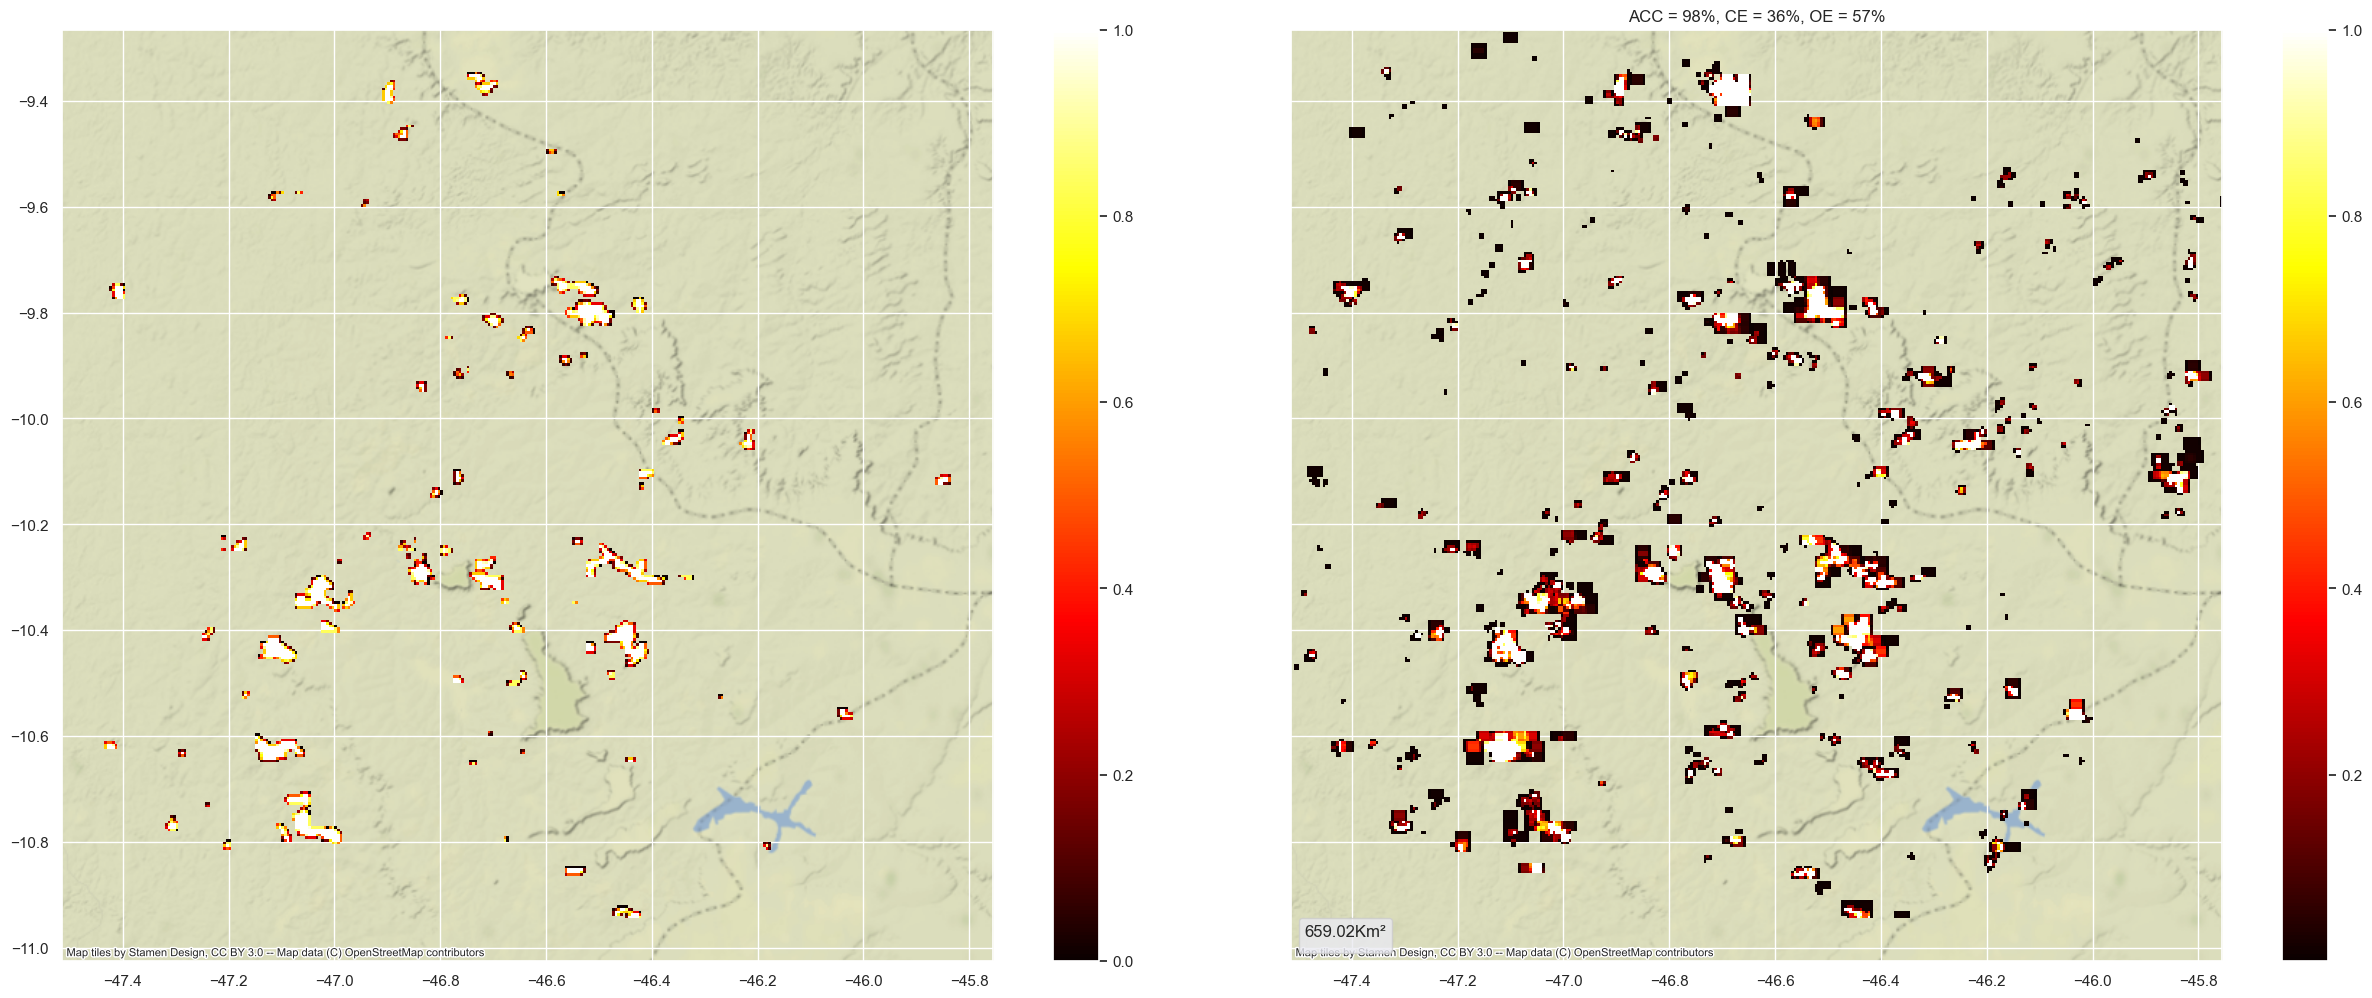

In [70]:
## Validaçao com o MCD64A1
mcd64a1 = read_gdf_from_tiff('tiff/MCD64A1.061_Burn_Date_doy2021182_aid0001.tif')
mcd64a1 = mcd64a1[mcd64a1['value'] > 0]
mcd64a1_gdf = normalize_gdf(mcd64a1, geometry, quadrat_width)
data, aqm, explore = compare_aqm_and_explore(mcd64a1_gdf, explore_temp_gdf, quadrat_width=quadrat_width, normatized=True)

In [142]:
import spatialpandas as spd
import xarray as xr

def create_dataarray(data: gpd.GeoDataFrame, value_column: str = 'value') -> xarray.DataArray:
    temp = data[data[value_column] > 0.0]
    points = temp.representative_point()
    idx = pd.MultiIndex.from_arrays(arrays=[points.y, points.x], names=["latitude","longitude"])
    s = pd.Series(temp[value_column].values, index=idx)
    return xr.DataArray.from_series(s, sparse=True)

def create_gpd(data: xr.DataArray, value_dim: str = 'value') -> gpd.GeoDataFrame:
    frame = data.to_dataframe(name=value_dim).reset_index()
    frame = frame[frame['value'] > 0.0]
    return gpd.GeoDataFrame(
        data=frame['value'], 
        geometry=gpd.points_from_xy(x=frame['longitude'], y=frame['latitude']))

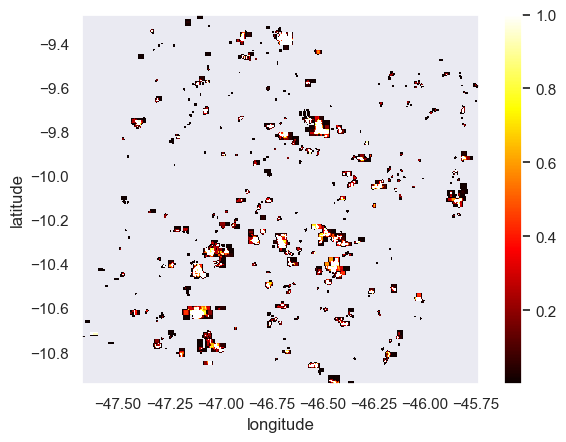

In [106]:
dataarray = create_dataarray(explore)
# explore[explore['value'] > 0.0].plot(column='value', cmap='hot', linewidth=0)
dataarray.plot(cmap='hot')

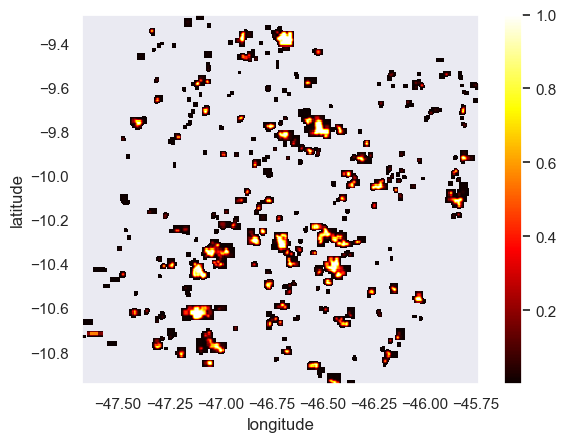

In [197]:
import cv2

dataarray = create_dataarray(explore)
# kernel = np.array([
#     [0   ,1/16, 1/8, 1/16, 0   ],
#     [1/16, 1/8, 1/4, 1/8, 1/16],
#     [1/8 , 1/6, 1/2, 1/6, 1/8 ],
#     [1/16, 1/8, 1/6, 1/8, 1/16],
#     [0   ,1/16, 1/8,1/16, 0   ],
# ])
kernel = np.array([
    [1/16, 1/8, 1/16],
    [1/8,  1/4, 1/8],
    [1/16, 1/8, 1/16],
])
dataarray.data = np.clip(cv2.filter2D(dataarray.fillna(0.0).to_numpy(), -1, kernel), 0.0, 1.0)
dataarray.where(dataarray > 0).plot(cmap='hot')